## Initialization

### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import os

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# to use the same matplotlib backend as Jupyter uses, so any GUI will shown
%matplotlib inline

# Regex
import re

# Modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

### User-defined Functions

In [ ]:
def data_info(data:pd.DataFrame or pd.Series, unique_limit:int or None=5) -> pd.DataFrame:
    '''
    Return a DataFrame info

    Parameters
    ----------
    data : DataFrame or Series
        the data to be displayed info
    unique_limit : int or None
        list of unique values, 'None' mean show all unique values limit by pandas option

    Returns
    -------
    DataFrame
        - Attribute : Column names of data
        - Data Type : Data type of data
        - Null Count : calculate count of null values
        - Null % : Percentage of null values
        - Unique Count : How many unique value
        - Unique Value : Unique value
    '''

    shape = data.shape
    null_pct = lambda x: np.around(x['Null Count'] * 100/len(data), 3)

    if type(data) == pd.DataFrame:
        info = data.dtypes.reset_index()
        info.columns = ['Attribute', 'Data Type']
        info['Null Count'] = data.isna().sum().values
        info['Null %'] = null_pct(info)
        info['Unique Count'] = data.nunique().values

        unique_value = []
        for col in data:
            unique_value.append(data[col].dropna().unique()[:unique_limit])
        info['Unique Value'] = unique_value

    elif type(data) == pd.Series:
        info = pd.DataFrame([data.name, data.dtype]).T
        info['Null Count'] = data.isna().sum()
        info['Null %'] = null_pct(info)
        info['Unique Count'] = data.nunique()
        info['Unique Value'] = [data.dropna().unique()[:unique_limit]]
        shape = shape+(1,)

    else:
        return 'Input DataFrame or Series Only'

    print('Total Observation (Rows): %d' %shape[0])
    print('Total Attributes (Columns): %d' %shape[1])
    return info

In [ ]:
def value_count_with_pct(data:pd.Series, orderby:str='Count', ascending:bool=False) -> pd.DataFrame:
    '''
    Return a DataFrame containing counts of unique rows in Series
    This is the same as the value_counts() function, but adds percentage

    Parameters
    ----------
    data: Series
        the data to be displayed value counts
    orderby: str (Count or Values)
        how to order the data, default Count
    ascending: bool (default: False)
        True for ascending, False for descending

    Returns
    ------
    DataFrame
        - Values : Values name
        - Count : Count per value
        - % : Percentage of count
    '''
    if type(data) == pd.Series:
        result = data.value_counts(dropna=False).reset_index() # don't use drop
        result.columns = ['Values', 'Count']
        result['%'] = np.around(result['Count'] * 100/len(data), 3)
        return result.sort_values(by=orderby, ascending=ascending)
    else:
        return 'Input Series only'

## Data Collecting

In [ ]:
path = './dataset/'
os.listdir(path)

['Preprocessed_data.csv',
 'BX_Books.csv',
 'BX-Book-Ratings.csv',
 'BX-Users.csv',
 'old']

In [ ]:
# read csv data
book = pd.read_csv(path+'BX_Books.csv', encoding='unicode_escape', sep=';')

# print first 5 data
book.head()

<ipython-input-6-c5adcc975240>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  book = pd.read_csv(path+'BX_Books.csv', encoding='unicode_escape', sep=';')


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
# read csv data
category = pd.read_csv(path+'Preprocessed_data.csv')[['isbn', 'Category']]

# renaming columns
category.rename(columns={'isbn':'ISBN'}, inplace=True)

# dropping duplicate data due to different uses from the original meaning
category.drop_duplicates(['ISBN'], inplace=True)

# print first 5 data
category.head()

,ISBN,Category
0,0195153448,['Social Science']
1,0002005018,['Actresses']
15,0060973129,['1940-1949']
18,0374157065,['Medical']
29,0393045218,['Design']


In [ ]:
# read csv data
ratings = pd.read_csv(path+'BX-Book-Ratings.csv', encoding='unicode_escape', sep=';')

# print first 5 data
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


## Data Understanding

### Data Information (Data Type, Null Count, Null Percentage, Unique Count, Unique Value)

In [ ]:
# data information in 'book'
data_info(book)

Total Observation (Rows): 271379
Total Attributes (Columns): 8


,Attribute,Data Type,Null Count,Null %,Unique Count,Unique Value
0,ISBN,object,0,0.000,271379,"[0195153448, 0002005018, 0060973129, 037415706..."
1,Book-Title,object,0,0.000,242154,"[Classical Mythology, Clara Callan, Decision i..."
2,Book-Author,object,1,0.000,102028,"[Mark P. O. Morford, Richard Bruce Wright, Car..."
3,Year-Of-Publication,object,0,0.000,202,"[2002, 2001, 1991, 1999, 2000]"
4,Publisher,object,2,0.001,16806,"[Oxford University Press, HarperFlamingo Canad..."
5,Image-URL-S,object,0,0.000,271063,[http://images.amazon.com/images/P/0195153448....
6,Image-URL-M,object,0,0.000,271063,[http://images.amazon.com/images/P/0195153448....
7,Image-URL-L,object,1,0.000,271062,[http://images.amazon.com/images/P/0195153448....


In [ ]:
# data information in 'ratings'
data_info(ratings)

Total Observation (Rows): 1149780
Total Attributes (Columns): 3


,Attribute,Data Type,Null Count,Null %,Unique Count,Unique Value
0,User-ID,int64,0,0.0,105283,"[276725, 276726, 276727, 276729, 276733]"
1,ISBN,object,0,0.0,340556,"[034545104X, 0155061224, 0446520802, 052165615..."
2,Book-Rating,int64,0,0.0,11,"[0, 5, 3, 6, 8]"


In [ ]:
# data information in 'category'
data_info(category)

Total Observation (Rows): 270170
Total Attributes (Columns): 2


,Attribute,Data Type,Null Count,Null %,Unique Count,Unique Value
0,ISBN,object,0,0.0,270170,"[0195153448, 0002005018, 0060973129, 037415706..."
1,Category,object,0,0.0,6448,"[['Social Science'], ['Actresses'], ['1940-194..."


## Data Preparation

### Remove Unnecessary Data


**Book Data**:
- **Image-URL-S, Image-URL-M, Image-URL-L**: contains image links, it does not help in the modeling process unless the image is extracted information and features from it. but unfortunetly we are not doing image recognition, so we can remove it

In [ ]:
print('Column Names Before:', book.columns.tolist())
dropped_column_main = ['Image-URL-S', 'Image-URL-M', 'Image-URL-L'] #'year_of_publication',
book = book.drop(dropped_column_main, axis=1).reset_index(drop=True)
print('Column Names After:', book.columns.tolist())

Column Names Before: ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']
Column Names After: ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']


**Book Rating Data**:
- **User-ID**: not used for modeling

In [ ]:
print('Column Names Before:', ratings.columns.tolist())
dropped_column_ratings = ['User-ID']
ratings = ratings.drop(dropped_column_ratings, axis=1).reset_index(drop=True)
print('Column Names After:', ratings.columns.tolist())

Column Names Before: ['User-ID', 'ISBN', 'Book-Rating']
Column Names After: ['ISBN', 'Book-Rating']


### Correcting Data Entry Errors

In [ ]:
# pd.set_option('display.max_rows', None)
value_count_with_pct(book['Year-Of-Publication'])['Values'].tolist()
# pd.reset_option('display.max_rows')

[1999,
 2000,
 2002,
 2001,
 1998,
 1997,
 1996,
 1995,
 2003,
 1994,
 1993,
 1992,
 1991,
 1990,
 1989,
 1988,
 1987,
 '2002',
 '2001',
 1986,
 '2003',
 '2000',
 1985,
 '1999',
 1984,
 '1998',
 2004,
 '1997',
 1983,
 0,
 1982,
 '1996',
 '1995',
 '1994',
 1981,
 '1993',
 '1992',
 '2004',
 '1991',
 1980,
 '1990',
 '1989',
 1978,
 1979,
 '1988',
 1977,
 '1987',
 '1986',
 1976,
 '1985',
 '0',
 '1984',
 '1983',
 '1982',
 1975,
 1974,
 1973,
 '1981',
 1972,
 '1980',
 '1979',
 '1977',
 '1978',
 1971,
 1970,
 '1976',
 '1975',
 1969,
 '1974',
 '1973',
 1968,
 '1972',
 1966,
 1965,
 1967,
 '1971',
 '1970',
 1960,
 1964,
 1961,
 1963,
 1962,
 1959,
 '1969',
 1958,
 1956,
 1957,
 '1967',
 1953,
 '1968',
 1955,
 '1964',
 '1966',
 '1965',
 1954,
 2005,
 '1963',
 1951,
 '1962',
 1920,
 1952,
 1940,
 '1961',
 '1959',
 '1960',
 '1955',
 1950,
 '1957',
 '1958',
 1911,
 '1956',
 '1954',
 1946,
 1942,
 1947,
 '1950',
 1930,
 '1953',
 1941,
 '1940',
 '2005',
 1923,
 1943,
 1939,
 '1951',
 1936,
 1901,
 19

In [ ]:
# find wtf people that input 'Year-Of-Publication' with 'Canterbury Press'
book[book['Year-Of-Publication'] == 'Canterbury Press']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
112280,1853114103,Lord Have Mercy,"""Ron"";2001""",Canterbury Press,http://images.amazon.com/images/P/1853114103.0...


In [ ]:
# assuming the column is shifted, then we shift it back to the correct column
book.loc[112280, 'Book-Author':] = 'Ron', 2001, 'Canterbury Press'
book.iloc[112280]

ISBN                         1853114103
Book-Title              Lord Have Mercy
Book-Author                         Ron
Year-Of-Publication                2001
Publisher              Canterbury Press
Name: 112280, dtype: object

In [ ]:
# find unusual year, this isn't data from the future
book[book['Year-Of-Publication'] == 2037]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
255426,068471809X,To Have and Have Not,Ernest Hemingway,2037,Simon & Schuster


In [ ]:
# assuming only typo, we change the year to 2007
book['Year-Of-Publication']  = book['Year-Of-Publication'].replace(2037, 2007)
book.iloc[255426]

ISBN                             068471809X
Book-Title             To Have and Have Not
Book-Author                Ernest Hemingway
Year-Of-Publication                    2007
Publisher                  Simon & Schuster
Name: 255426, dtype: object

In [ ]:
# find a year with a value of 0 or '0', maybe it's a book that was released before the Gregorian era.
print('Amount of Data:', len(book[(book['Year-Of-Publication'] == '0') | (book['Year-Of-Publication'] == 0)]))
display(book[(book['Year-Of-Publication'] == '0') | (book['Year-Of-Publication'] == 0)])

Amount of Data: 4619


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
176,3150000335,Kabale Und Liebe,Schiller,0,"Philipp Reclam, Jun Verlag GmbH"
188,342311360X,Die Liebe in Den Zelten,Gabriel Garcia Marquez,0,Deutscher Taschenbuch Verlag (DTV)
288,0571197639,Poisonwood Bible Edition Uk,Barbara Kingsolver,0,Faber Faber Inc
351,3596214629,"Herr Der Fliegen (Fiction, Poetry and Drama)",Golding,0,Fischer Taschenbuch Verlag GmbH
542,8845229041,Biblioteca Universale Rizzoli: Sulla Sponda De...,P Coelho,0,Fabbri - RCS Libri
...,...,...,...,...,...
270813,014029953X,Foe (Essential.penguin S.),J.M. Coetzee,0,Penguin Books Ltd
270932,0340571187,Postmens House,Maggie Hemingway,0,Trafalgar Square
271113,8427201079,El Misterio De Sittaford,Agatha Christie,0,Editorial Molino
271201,0887781721,Tom Penny,Tony German,0,P. Martin Associates


In [ ]:
# converts this 0 or '0' value into nan
book['Year-Of-Publication']  = book['Year-Of-Publication'].replace(0, np.nan)
book['Year-Of-Publication']  = book['Year-Of-Publication'].replace('0', np.nan)

# print the result
print('Amount of Data:', len(book[(book['Year-Of-Publication'] == '0') | (book['Year-Of-Publication'] == 0)]))

Amount of Data: 0


### Calculate Average Ratings

In [ ]:
round(ratings.groupby(['ISBN'])['Book-Rating'].mean(),1)

ISBN
 0330299891    3.0
 0375404120    1.5
 0586045007    0.0
 9022906116    3.5
 9032803328    0.0
              ... 
cn113107       0.0
ooo7156103     7.0
§423350229     0.0
´3499128624    8.0
Ô½crosoft      7.0
Name: Book-Rating, Length: 340556, dtype: float64

In [ ]:
# groupby 'ISBN' and calculate mean of 'Book-Rating'
ratings_avg = round(ratings.groupby(['ISBN'])['Book-Rating'].mean(), 1)
ratings_avg = ratings_avg.reset_index()

# renaming columns name
ratings_avg.rename(columns={'Book-Rating': 'AVG-Book-Rating'}, inplace=True)

# print first 5 data and total rows
display(ratings_avg.head())
print('\nTotal Rows:', len(ratings_avg))

,ISBN,AVG-Book-Rating
0,0330299891,3.0
1,0375404120,1.5
2,0586045007,0.0
3,9022906116,3.5
4,9032803328,0.0



Total Rows: 340556


### Merge Book, Category, and Ratings Data

In [ ]:
book_with_category_ratings = book.merge(category, on='ISBN', how='left')
book_with_category_ratings = book_with_category_ratings.merge(ratings_avg, on='ISBN', how='left')
book_with_category_ratings.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Category,AVG-Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,['Social Science'],0.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,['Actresses'],4.9
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,['1940-1949'],5.0
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,['Medical'],4.3
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,['Design'],0.0


### Handling Missing Value

#### book_with_category

In [ ]:
# check missing value in 'book_with_category_ratings'
book_with_category_ratings.isna().sum()

ISBN                      0
Book-Title                0
Book-Author               1
Year-Of-Publication    4619
Publisher                 2
Category               1209
AVG-Book-Rating        1209
dtype: int64

In [ ]:
print('Rows Before:', len(book_with_category_ratings))
book_with_category_ratings.dropna(subset=['Year-Of-Publication','Category','AVG-Book-Rating'], inplace=True)
print('Rows After:', len(book_with_category_ratings))

Rows Before: 271379
Rows After: 265572


In [ ]:
book_with_category_ratings[book_with_category_ratings.isna().any(axis=1)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Category,AVG-Book-Rating
128896,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN,['Fiction'],9.0
129043,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,['Fiction'],9.0
187700,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,9,8.0


In [ ]:
book_with_category_ratings.fillna('Unknown', inplace=True)
book_with_category_ratings.loc[[128896, 129043, 187700]]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Category,AVG-Book-Rating
128896,193169656X,Tyrant Moon,Elaine Corvidae,2002,Unknown,['Fiction'],9.0
129043,1931696993,Finders Keepers,Linnea Sinclair,2001,Unknown,['Fiction'],9.0
187700,9627982032,The Credit Suisse Guide to Managing Your Perso...,Unknown,1995,Edinburgh Financial Publishing,9,8.0


### Dealing with Duplicated Value

In [ ]:
print('Jumlah Data Duplikat (book_with_category_ratings):', book_with_category_ratings.duplicated(['ISBN']).sum())

Jumlah Data Duplikat (book_with_category_ratings): 0


### Correcting Data Type

In [ ]:
book_with_category_ratings.dtypes

ISBN                    object
Book-Title              object
Book-Author             object
Year-Of-Publication     object
Publisher               object
Category                object
AVG-Book-Rating        float64
dtype: object

In [ ]:
book_with_category_ratings['Year-Of-Publication'] = book_with_category_ratings['Year-Of-Publication'].astype(int)
book_with_category_ratings['Year-Of-Publication'].dtype

dtype('int64')

### Clean Text in Categories

In [ ]:
# # analyze what needs to be cleaned in csv (external analysis)
# book_with_category['Category'].value_counts().reset_index()['index'].to_csv('dirty_text.csv')

In [ ]:
# function to remove [, ], ', " in front and back of the sentence
def clean_text(text):
  return re.sub(r'''^[\[\'\"\]]+|[\[\'\"\]]+$''', '', text)

In [ ]:
# analyze 'clean_text' results
dirty_vs_clean = book_with_category_ratings['Category']

# apply 'clean_text' function
dirty_vs_clean = pd.concat([dirty_vs_clean, dirty_vs_clean.apply(clean_text)], axis=1)

# renaming columns name
dirty_vs_clean.columns = ['dirty', 'clean']

# create unique for analyzing
dirty_vs_clean = dirty_vs_clean.value_counts(['dirty', 'clean']).reset_index().drop(0, axis=1)

# export to csv for external analysis
# dirty_vs_clean.to_csv('dirty_clean_text.csv')

# print data
dirty_vs_clean

,dirty,clean
0,9,9
1,['Fiction'],Fiction
2,['Juvenile Fiction'],Juvenile Fiction
3,['Biography & Autobiography'],Biography & Autobiography
4,['Religion'],Religion
...,...,...
6318,['Anxiety in children'],Anxiety in children
6319,['Antwerp (Belgium)'],Antwerp (Belgium)
6320,['Emotions.'],Emotions.
6321,['Employee motivation.'],Employee motivation.


In [ ]:
# apply 'clean_text' function
book_with_category_ratings['Category'] = book_with_category_ratings['Category'].apply(clean_text)

# print first 5 data
book_with_category_ratings.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Category,AVG-Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,Social Science,0.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,Actresses,4.9
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,1940-1949,5.0
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,Medical,4.3
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,Design,0.0


### Handling Unusual Data

#### Category

In [ ]:
# analyze unusual category with 'value_count_with_pct' function
value_count_with_pct(book_with_category_ratings['Category'])

,Values,Count,%
0,9,128052,48.217
1,Fiction,53077,19.986
2,Juvenile Fiction,10270,3.867
3,Biography & Autobiography,5371,2.022
4,Religion,3521,1.326
...,...,...,...
3778,Volunteer workers in community development,1,0.000
3779,"Monroe, Darci (Fictitious character)",1,0.000
3780,Junger Mann - Schuldgefühl - Vater - Flugzeuga...,1,0.000
3781,Garden pests,1,0.000


In [ ]:
# check what data that have '9' value in Category columns
book_with_category_ratings[book_with_category_ratings['Category'] == '9'].head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Category,AVG-Book-Rating
7,0671870432,PLEADING GUILTY,Scott Turow,1993,Audioworks,9,2.7
12,0887841740,The Middle Stories,Sheila Heti,2004,House of Anansi Press,9,2.5
13,1552041778,Jane Doe,R. J. Kaiser,1999,Mira Books,9,5.0
14,1558746218,A Second Chicken Soup for the Woman's Soul (Ch...,Jack Canfield,1998,Health Communications,9,3.4
15,1567407781,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998,Brilliance Audio - Trade,9,6.0


In [ ]:
# drop all rows that have '9' value in Category columns
book_with_category_ratings = book_with_category_ratings[book_with_category_ratings['Category'] != '9']

### Remove categories that have <100 and ≥1400 book data (due to resource limitation)

In [ ]:
# Category <100
category_under_100 = book_with_category_ratings['Category'].value_counts()[book_with_category_ratings['Category'].value_counts() < 100]
category_under_100 = category_under_100.index.tolist()

# Category ≥ 1400
category_over_1400 = book_with_category_ratings['Category'].value_counts()[book_with_category_ratings['Category'].value_counts() > 1400]
category_over_1400 = category_over_1400.index.tolist()

# result >100
print('Book Category <100 Data:', len(category_under_100))
print('Sample <100 Data:', category_under_100[:10])

# result ≥1400
print('Book Category ≥100 Data:', len(category_over_1400))
print('Sample ≥1000 Data:', category_over_1400[:10])

Book Category <100 Data: 6251
Sample <100 Data: ['Fantasy fiction', 'United States', 'Christmas stories', 'Children', 'Conduct of life', 'Authors, American', 'Romance fiction', 'Bears', 'Fantasy', 'American poetry']
Book Category ≥100 Data: 14
Sample ≥1000 Data: ['Fiction', 'Juvenile Fiction', 'Biography & Autobiography', 'Religion', 'History', 'Juvenile Nonfiction', 'Social Science', 'Business & Economics', 'Body, Mind & Spirit', 'Health & Fitness']


In [ ]:
# Remove category >100 and ≥1400
print('Rows Before:', len(book_with_category_ratings))
book_with_category_ratings = book_with_category_ratings[~book_with_category_ratings['Category'].isin(category_under_100)]
book_with_category_ratings = book_with_category_ratings[~book_with_category_ratings['Category'].isin(category_over_1400)]
print('Rows After:', len(book_with_category_ratings))

Rows Before: 137520
Rows After: 24444


### Final Data Check and Visualization

#### Final Data Information (data type, null count, null percentage, unique count)

In [ ]:
# Data Information (book_with_category_ratings)
data_info(book_with_category_ratings)

Total Observation (Rows): 24444
Total Attributes (Columns): 7


,Attribute,Data Type,Null Count,Null %,Unique Count,Unique Value
0,ISBN,object,0,0.0,24444,"[0374157065, 0393045218, 1575663937, 187938449..."
1,Book-Title,object,0,0.0,23867,[Flu: The Story of the Great Influenza Pandemi...
2,Book-Author,object,0,0.0,17800,"[Gina Bari Kolata, E. J. W. Barber, Robert Hen..."
3,Year-Of-Publication,int64,0,0.0,72,"[1999, 2003, 1978, 2001, 1988]"
4,Publisher,object,0,0.0,3682,"[Farrar Straus Giroux, W. W. Norton & Company,..."
5,Category,object,0,0.0,57,"[Medical, Design, Nature, Reference, Science]"
6,AVG-Book-Rating,float64,0,0.0,95,"[4.3, 0.0, 2.0, 3.3, 1.1]"


#### Density Distribution of AVG-Book-Rating

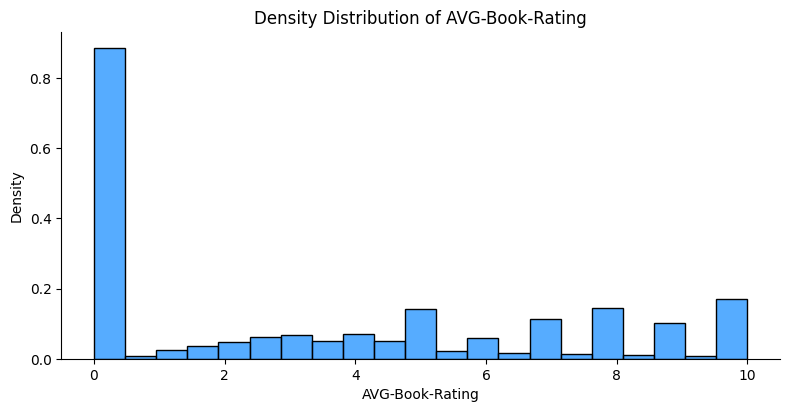

In [ ]:
sns.displot(data=book_with_category_ratings, x='AVG-Book-Rating',
            stat='density', color='dodgerBlue', height=4, aspect=2)
plt.title('Density Distribution of AVG-Book-Rating')
plt.show()

#### Amount of Data per Category

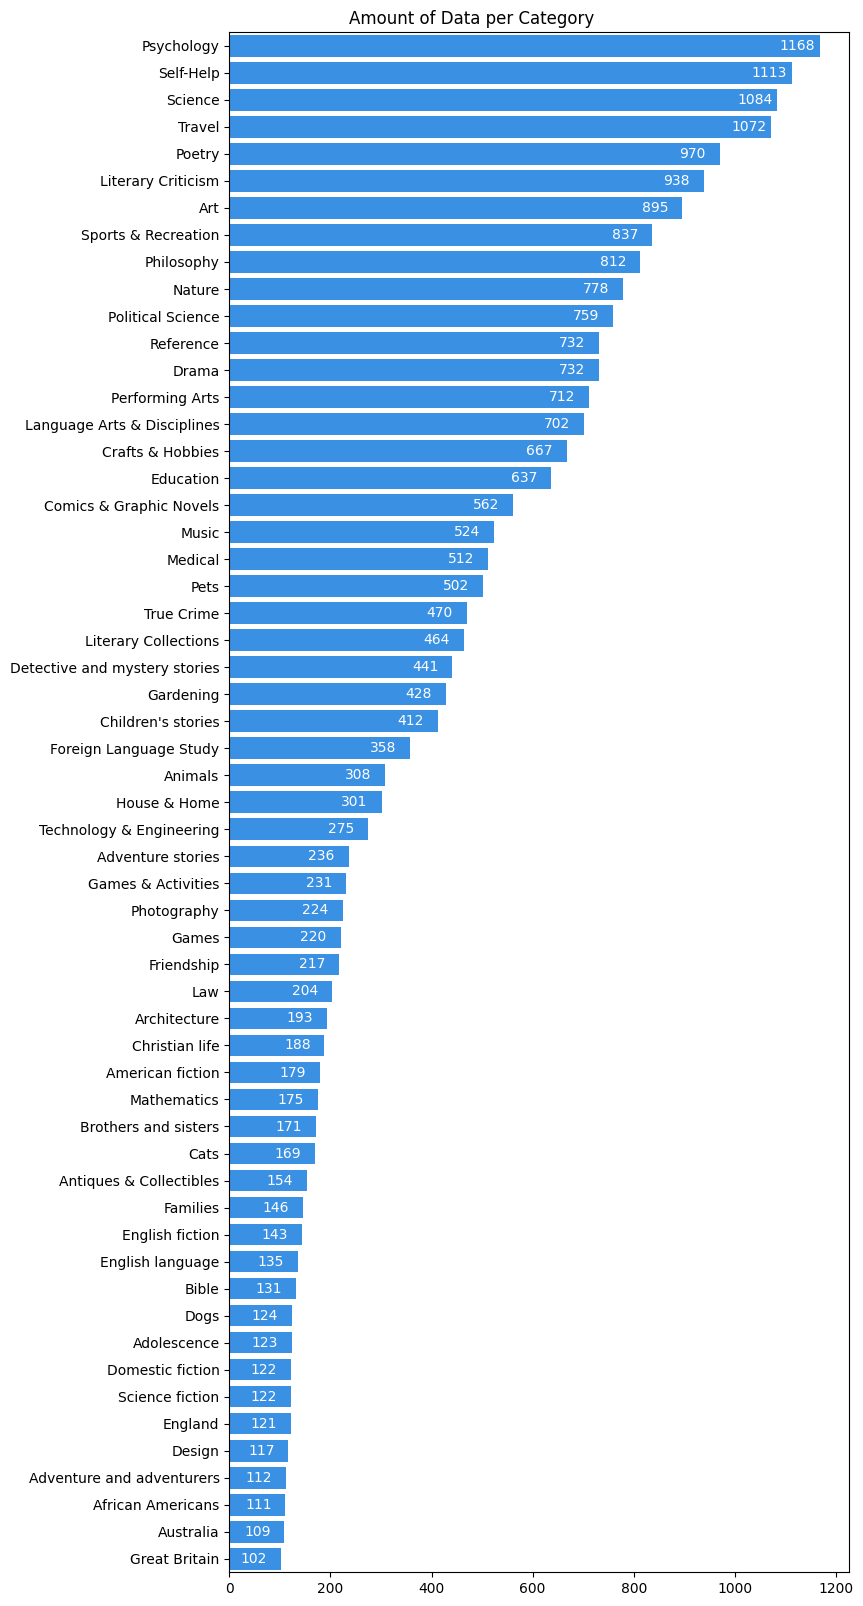

In [ ]:
plt.figure(figsize=(8,20))

# # order by category names
# ax = sns.countplot(y=book_with_category_ratings['Category'].sort_values(), color='dodgerBlue')

# order by count
order = book_with_category_ratings.groupby('Category').size().sort_values().index[::-1]
ax = sns.countplot(y=book_with_category_ratings['Category'], color='dodgerBlue', order=order)

ax.bar_label(ax.containers[0], fmt='%i', padding=-29, color='white')
plt.title('Amount of Data per Category', x=0.39) # x for x-axis movement
plt.xlabel(None)
plt.ylabel(None)
plt.show()

In [ ]:
print('Amount of categories:', len(book_with_category_ratings.groupby('Category').size()))

Amount of categories: 57


#### Amount of Book Publications by Year

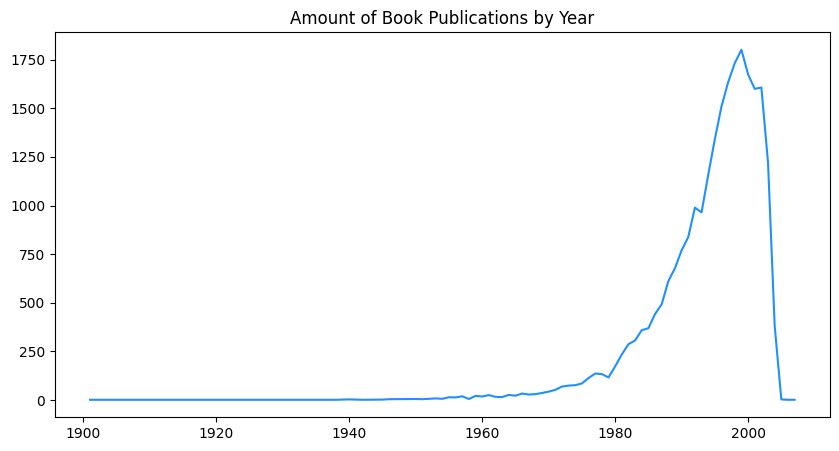

In [ ]:
year_count = book_with_category_ratings['Year-Of-Publication'].value_counts().reset_index()
year_count.columns = ['year', 'count']

plt.figure(figsize=(10,5))
sns.lineplot(data=year_count, x='year', y='count', color='dodgerBlue')
plt.ylabel(None)
plt.xlabel(None)
plt.title('Amount of Book Publications by Year')
plt.show()

In [ ]:
print('Start Year:', min(year_count.year))
print('End Year:', max(year_count.year))

Start Year: 1901
End Year: 2007


## Modeling

In [ ]:
# vectorize 'Category' to create each columns
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(book_with_category_ratings['Category'])

In [ ]:
# calculate cosine similarity from 'tfidf_matrix'
similarities = cosine_similarity(tfidf_matrix)

In [ ]:
# create similarities result dataframe
similarities_result = pd.DataFrame(similarities, index=book_with_category_ratings['Book-Title'], columns=book_with_category_ratings['Book-Title'])
similarities_result.sample(10, random_state=42).sample(4, axis=1, random_state=4242)

Book-Title,Baseball Letters: A Fan's Correspondence With His Heroes,The Works of Robert Browning,The Happy Isles of Oceania: Paddling the Pacific,Psychology
Book-Title,,,,
Daily Word for Families: Linking My Heart With Those I Love (Daily Word),0.0,0.0,0.0,0.0
Sweet Valley High #03: Playing with Fire (Sweet Valley High (Numbered Paperback)),0.0,0.0,0.0,0.0
Book of Musical Anecdotes,0.0,0.0,0.0,0.0
Private Landscapes,0.0,0.0,0.0,0.0
Collins Gem Irish Dictionary (Collins Gem),0.0,0.0,0.0,0.0
What's the Opposite of a Best Friend?,0.0,0.0,0.0,0.0
Carrer BolÃ­via (El BalancÃ­),0.0,0.0,0.0,0.0
Mortal gods: A novel,0.0,0.0,0.0,0.0
"The Scythe BookSecond Edition Mowing Hay, Cutting Weeds, and Harvesting Small Grains with Hand Tools",0.0,0.0,0.0,0.0


In [ ]:
def get_recommendations(book_title:str, recommendation_limit:int=10, similarities_data:pd.DataFrame=similarities_result, book_data:pd.DataFrame=book_with_category_ratings) -> pd.DataFrame:
    '''
    Get top book recommendations with the highest rating

    Parameters
    ----------
    book_title : str
        book titles for which other book recommendations will be sought
    similarities_data : pd.DataFrame
        book similarity dataset
    book_data: DataFrame
        contains both names and other features used to define similarity
    recommendation_limit : int
        limit of recommendation books to be provided

    Returns
    -------
    result : DataFrame
        top book recommendations with the highest rating, limit by recommendation_limit

    '''

    index = similarities_data.loc[:,book_title].to_numpy().argpartition(range(-1, -(recommendation_limit+2), -1))
    most_similiar = similarities_data.columns[index[-1:-(recommendation_limit+2):-1]]
    most_similiar = most_similiar.drop(book_title, errors='ignore')
    recomendations = pd.DataFrame(most_similiar).merge(book_data).head(recommendation_limit)

    return book_title, recomendations.sort_values(['AVG-Book-Rating'], ascending=False)

In [ ]:
# find book title references
sample_book = book_with_category_ratings.sample(2, random_state=37)
sample_book

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Category,AVG-Book-Rating
215292,0817454012,The Perfect Portfolio,Henrietta Brackman,1984,Amphoto Books,Photography,0.0
254821,0811730875,The Smart Gardener's Guide to Growing Vegetables,Bob Gough,1996,Stackpole Books,Gardening,0.0


In [ ]:
# get top recommendation for "The Perfect Portfolio"
title_1, recommendations_1 = get_recommendations('The Perfect Portfolio', 5)
print('Book Title:', title_1)
display(recommendations_1)

Book Title: The Perfect Portfolio


,Book-Title,ISBN,Book-Author,Year-Of-Publication,Publisher,Category,AVG-Book-Rating
4,Friendship: Celebration of Humanity (M.I.L.K.),0066209706,MILK Project,2001,William Morrow,Photography,10.0
2,The Best of Life,0380449099,David E. Scherman,1987,Avon Books,Photography,5.0
1,The Sky's the Limit: A Defense of the Earth,0393307174,John Nichols,1990,W. W. Norton & Company,Photography,2.7
0,Magic Eye: The Amazing Spider-Man 3d Illusions,0836213327,Magic Eye Inc.,1996,Andrews McMeel Pub,Photography,0.0
3,KODAK GREAT PICTURE,0671541374,Kodak Unknown,1984,Fireside,Photography,0.0


In [ ]:
# get top recommendation for "The Smart Gardener's Guide to Growing Vegetables"
title_2, recommendations_2 = get_recommendations("The Smart Gardener's Guide to Growing Vegetables", 5)
print('Book Title:', title_2)
display(recommendations_2)

Book Title: The Smart Gardener's Guide to Growing Vegetables


,Book-Title,ISBN,Book-Author,Year-Of-Publication,Publisher,Category,AVG-Book-Rating
1,Mushrooms Demystified: A Comprehensive Guide t...,0898151694,David Arora,1986,Ten Speed Press,Gardening,10.0
3,Better Homes and Gardens New Garden Book,0696025574,Better Homes and Gardens,1993,Meredith Books,Gardening,9.0
2,Hydroponics for the Home Gardener,1550133756,Stewart Kenyon,1992,Key Porter Books,Gardening,8.0
0,Cultivating Sacred Space: Gardening for the Soul,0764903608,Elizabeth Murray,1998,Pomegranate Communications,Gardening,5.0
4,Yardening,0025064312,Jeff Ball,1992,Macmillan General Reference,Gardening,0.0


# Evaluation

In [61]:
def get_precision(book_title:str, recommendations:pd.DataFrame, threshold:int=5) -> pd.DataFrame:
    '''
    Get top book recommendations with the highest rating

    Parameters
    ----------
    book_title : str
        book titles for which other book recommendations will be sought
    recommendations : pd.DataFrame
        recommendations result dataframe
    treshold : int
        dividing value to categorize the results as good or bad

    Returns
    -------
    book_title
        book title
    precision
        precision score
    '''

    book_ratings = recommendations['AVG-Book-Rating'].values
    book_relevances = book_ratings >= threshold
    book_non_relevances = book_ratings < threshold
    precision = len(book_ratings[book_relevances]) / len(recommendations)

    print('Book Title:', book_title)
    print('Relevant Ratings:', book_ratings[book_relevances])
    print('Non-Relevant Ratings:', book_ratings[book_non_relevances])
    print('Precision Score:', precision)

In [62]:
# get precision for "The Perfect Portfolio"
get_precision(title_1, recommendations_1)

Book Title: The Perfect Portfolio
Relevant Ratings: [10.  5.]
Non-Relevant Ratings: [2.7 0.  0. ]
Precision Score: 0.4


In [63]:
# get precision for "The Smart Gardener's Guide to Growing Vegetables"
get_precision(title_2, recommendations_2)

Book Title: The Smart Gardener's Guide to Growing Vegetables
Relevant Ratings: [10.  9.  8.  5.]
Non-Relevant Ratings: [0.]
Precision Score: 0.8
